In [43]:
# Module imports
import skimage
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import math

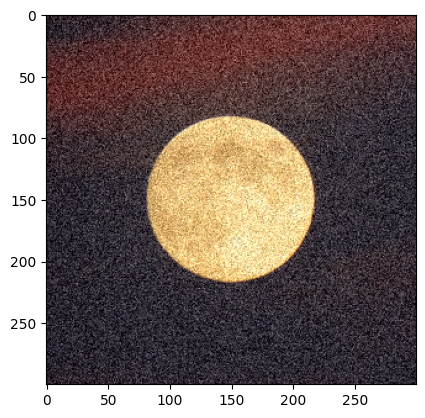

In [37]:
# Question 1
img = skimage.io.imread("./data/moon_noisy.png")
plt.imshow(img);

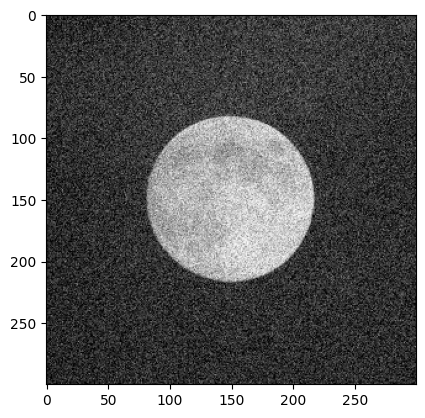

In [35]:
grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(grayscale_img, "gray");

s_g that minimizes s_w**2: 2.5


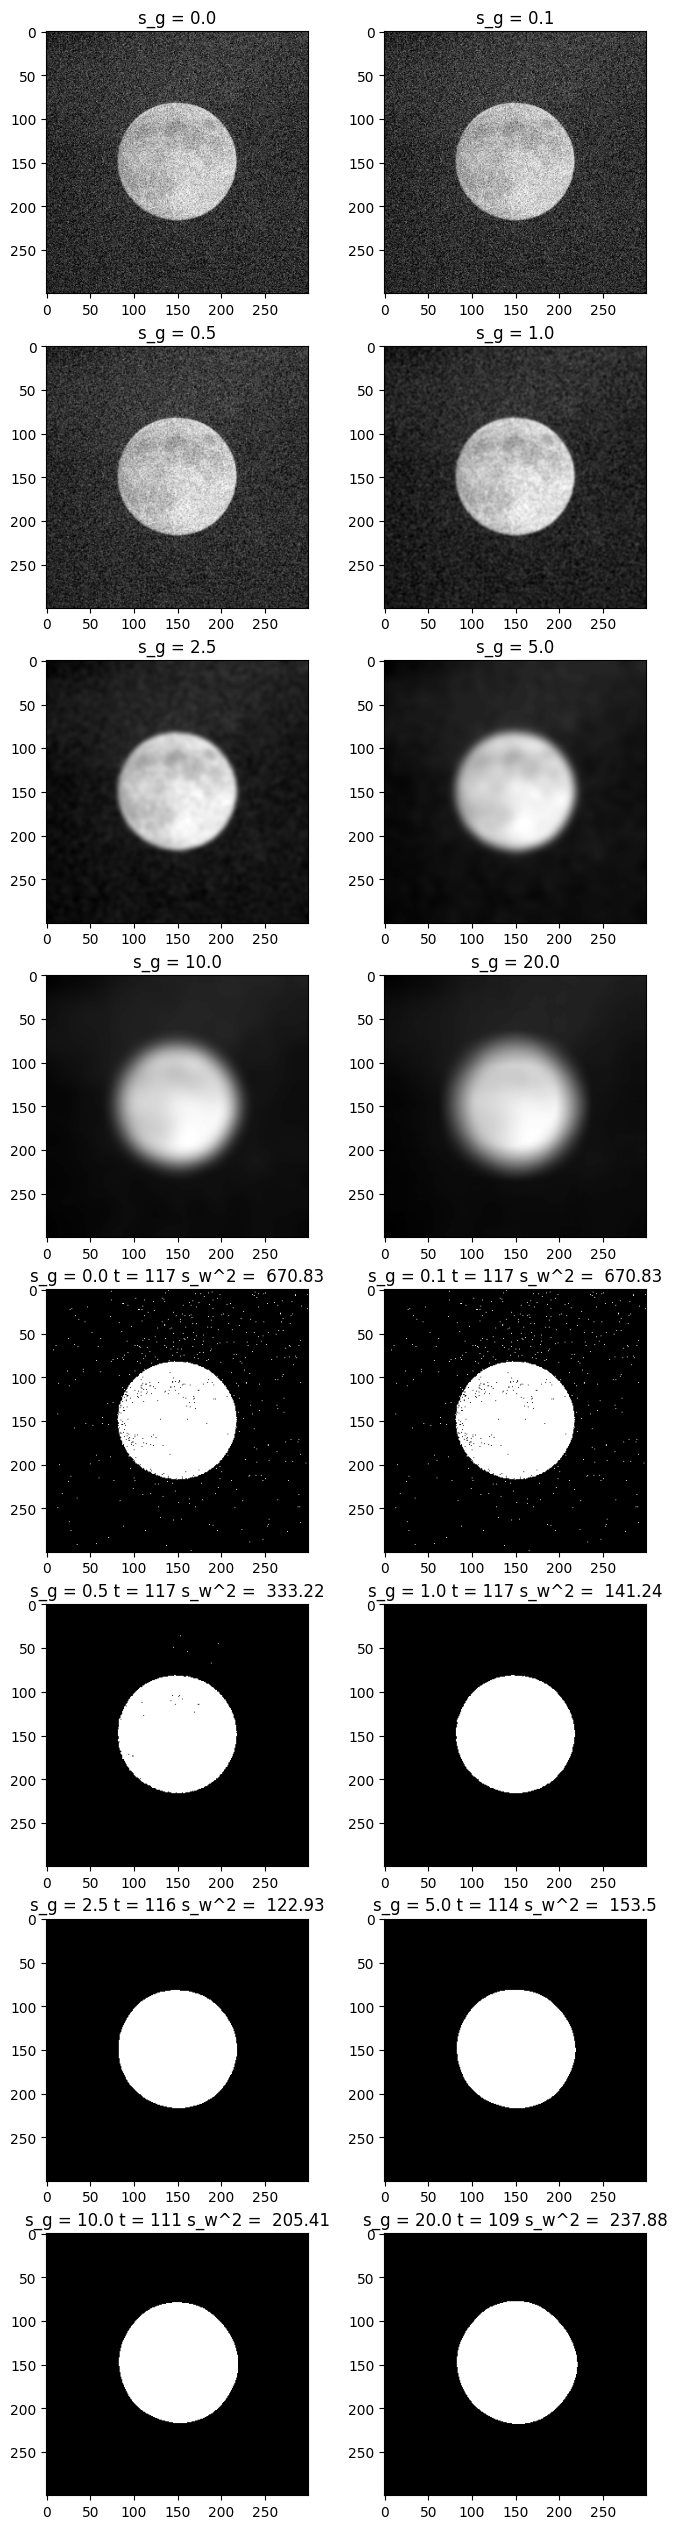

In [202]:
def between_class_variance(img, t): 
    freq = np.zeros(256)
    for i in range(256):
        freq[i] = np.sum(img==i)
    m, n = img.shape
    p = freq/(m*n)
    # Class probabilities
    w0 = np.sum(p[:t+1])
    w1 = np.sum(p[t+1:])
    # image mean
    uT = np.sum(np.arange(256)*p)
    if w0==0 or w1==0:
        return -np.inf
    # Mean value of intensity of a pixel belonging to a class
    u0 = np.sum(np.arange(t+1)*p[:t+1])/w0
    u1 = np.sum(np.arange(t+1,256)*p[t+1:])/w1
    # Between class variance
    return w0*(u0-uT)**2 + w1*(u1-uT)**2 

def adaptive_binarization(img, block_size):
    M, N = img.shape
    m, n = M//block_size, N//block_size
    v_s, h_s = 0, 0
    binarized_image = np.zeros((M, N))
    t, min_within_class_variance = None, None

    def within_class_variance(t, p):  # sw^2 = w0 * s0^2 + w1 * s1^2
        # Class probabilities
        w0 = np.sum(p[:t+1])
        w1 = np.sum(p[t+1:])
        if w0==0 or w1==0:
            return np.inf
        # Mean value of intensity of a pixel belonging to a class
        u0 = np.sum([k*p[k] for k in range(t+1)]) / w0
        u1 = np.sum([k*p[k] for k in range(t+1, 256)]) / w1
        # Variance of intensities of pixel belonging to a class
        s0 = np.sum([((k-u0)**2)*p[k] for k in range(t+1)]) / w0
        s1 = np.sum([((k-u1)**2)*p[k] for k in range(t+1, 256)]) / w1
        # Within class variance
        return w0*s0 + w1*s1

    while v_s < block_size:
        freq = np.zeros(256)
        img_plot = img[h_s*m:h_s*m+n, v_s*n:v_s*n+m]
        for i in range(256):
            freq[i] = np.sum(img_plot==i)
        p = freq / (m*n)
        within_class_variance_t = np.zeros(256)
        for t in range(256):
            within_class_variance_t[t] = within_class_variance(t, p)
        t = np.argmin(within_class_variance_t)
        min_within_class_variance = np.min(within_class_variance_t)
        for i in range(m):
            for j in range(n):
                if img[h_s*m+i, v_s*n+j] > t:
                    binarized_image[h_s*m+i,v_s*n+j] = 1
                else:
                    binarized_image[h_s*m+i,v_s*n+j] = 0
        h_s += 1
        if h_s == block_size:
            h_s = 0
            v_s += 1
    return min_within_class_variance, t, binarized_image

def kernel(M, N, s_g):
    filter = np.zeros((M, N))
    if s_g==0:
        filter[M//2, N//2] = 1
        return filter
    for i in np.arange(-M//2, M//2+1, 1):
        for j in np.arange(-N//2, N//2+1, 1):
            filter[i+M//2, j+N//2] = np.exp(-((i**2+j**2)/(2*s_g**2)))
    filter = filter / np.sum(filter)
    return filter

s_gs = np.array([0, 0.1, 0.5, 1, 2.5, 5, 10, 20])
within_class_variance = np.zeros(len(s_gs))
fig, axs = plt.subplots(8, 2, figsize=(8, 32))
axes = axs.flat
for i in range(len(s_gs)):
    filter = kernel(41, 41, s_gs[i])
    img_ = cv2.filter2D(grayscale_img,0, filter)
    axes[i].imshow(img_, 'gray')
    axes[i].set_title(f"s_g = {s_gs[i]}")
    within_class_variance[i], t, binarized_img = adaptive_binarization(img_, block_size=1)
    axes[i+8].imshow(binarized_img, 'gray')
    axes[i+8].set_title(f"s_g = {s_gs[i]} t = {t} s_w^2 =  {np.round(within_class_variance[i], 2)}")
print(f's_g that minimizes s_w**2: {s_gs[np.argmin(within_class_variance)]}')
plt.show();

227 400


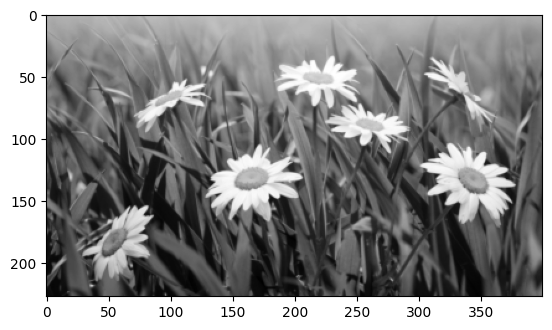

In [65]:
# Question 2
img2 = skimage.io.imread("./data/flowers.png")
M, N = img2.shape[0], img2.shape[1]
print(M ,N)
plt.imshow(img2, "gray");

In [186]:
def bilinear_interpolation(img, x, y):
    M, N = img.shape[0], img.shape[1]
    x1, y1 = math.floor(x), math.floor(y)
    x2, y2 = min(x1 + 1, M-1), min(y1 + 1, N-1)
    A0, A1 = 0, 0
    if x1 != x2:
        A0 = (x - x1) / (x2 - x1)
    if y1 != y2:
        A1 = (y2 - y) / (y2 - y1)
    
    f_x_y1 = img[x2, y1]*A0 + img[x1, y1]*(1-A0)
    f_x_y2 = img[x2, y2]*A0 + img[x1, y2]*(1-A0)
    f_x_y = f_x_y1*A1 + f_x_y2*(1-A1)
    return f_x_y

In [167]:
M1, N1 = math.floor(M/2), math.floor(N/2)
M2, N2 = M1*3, N1*3

In [168]:
downsampled_img = np.zeros((M1, N1))
upsampled_img = np.zeros((M2, N2))

In [170]:
print(downsampled_img.shape)
print(upsampled_img.shape)

(113, 200)
(339, 600)


In [172]:
downsampled_img_cv = cv2.resize(img2, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
upsampled_img_cv = cv2.resize(downsampled_img_cv, (0,0), fx=3, fy=3, interpolation=cv2.INTER_LINEAR)

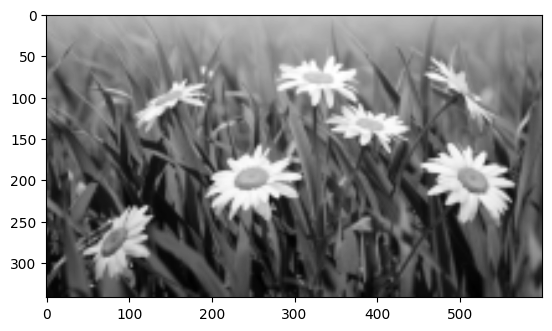

In [171]:
plt.imshow(upsampled_img_cv, 'gray');

In [197]:
for i in range(M1):
    for j in range(N1):
        downsampled_img[i, j] = bilinear_interpolation(img2, i/0.5, j/0.5)
for i in range(M2):
    for j in range(N2):
        upsampled_img[i, j] = bilinear_interpolation(downsampled_img, i/3, j/3)
        # downsampled_img[i, j] = i/a, i/b
# for i in range(M):
#     for j in range(N):
#         upsampled_img[i, j] = downsampled_img[i]

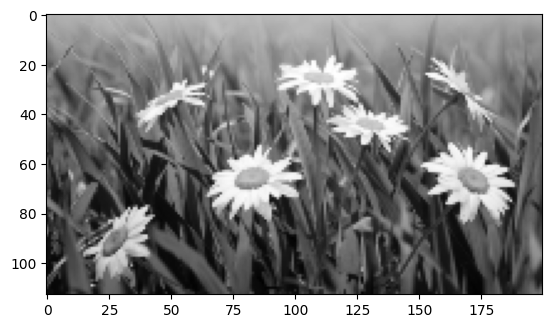

In [198]:
plt.imshow(downsampled_img, 'gray');

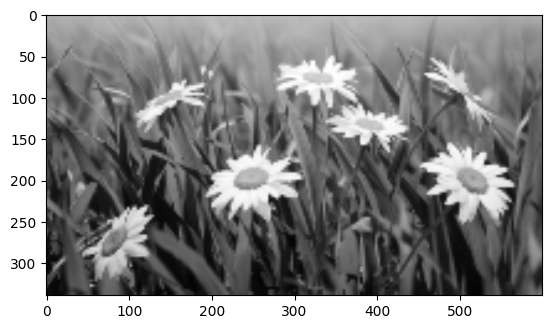

In [199]:
plt.imshow(upsampled_img, 'gray');

In [200]:
for i in range(M2):
    for j in range(N2):
        upsampled_img[i, j] = bilinear_interpolation(img2, i/1.5, j/1.5)

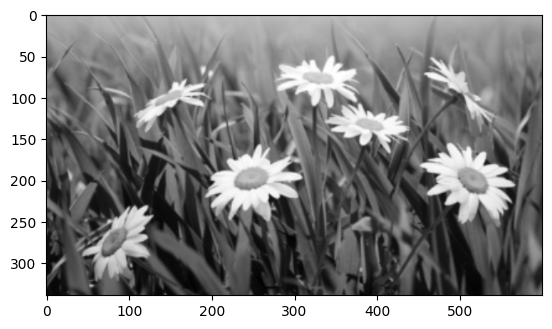

In [201]:
plt.imshow(upsampled_img, 'gray');

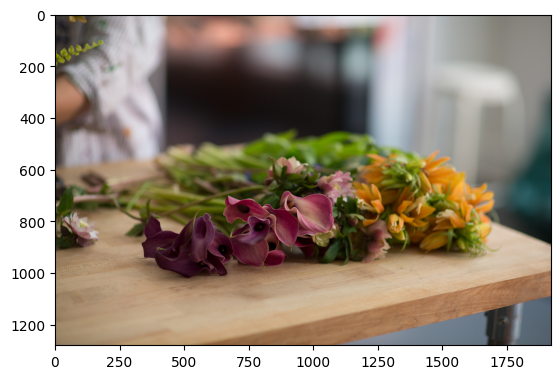

In [225]:
# Question 3
# Brightness Adjust
img3 = skimage.io.imread("./data/brightness_contrast.jpg")
plt.imshow(img3);

In [235]:
img3[:,:,0]

array([[ 63,  65,  65, ..., 132, 129, 127],
       [ 65,  64,  61, ..., 129, 129, 133],
       [ 62,  64,  65, ..., 128, 127, 126],
       ...,
       [140, 139, 145, ...,  82,  81,  82],
       [138, 139, 141, ...,  78,  79,  82],
       [141, 140, 136, ...,  80,  83,  81]], dtype=uint8)

In [378]:
def brightnessAdjust(img, p):
    img = img.copy()
    img[:,:,0] = np.clip(img[:,:,0] + (p-0.5)*255, 0, 255)
    img[:,:,1] = np.clip(img[:,:,1] + (p-0.5)*255, 0, 255)
    img[:,:,2] = np.clip(img[:,:,2] + (p-0.5)*255, 0, 255)
    return img

def contastAdjust(img, p):
    img = img.copy()
    avg_intensity = np.mean(img3, axis=(0, 1))
    for c in range(3):
        img[:,:,c] = np.where(img[:,:,c] > avg_intensity[c], np.clip(np.int32(img[:,:,c] + (0.5-p)*(avg_intensity[c]-img[:,:,c])), 0, 255), np.clip(np.int32(img[:,:,c] - (0.5-p)*(img[:,:,c]-avg_intensity[c])), 0, 255))
    return img

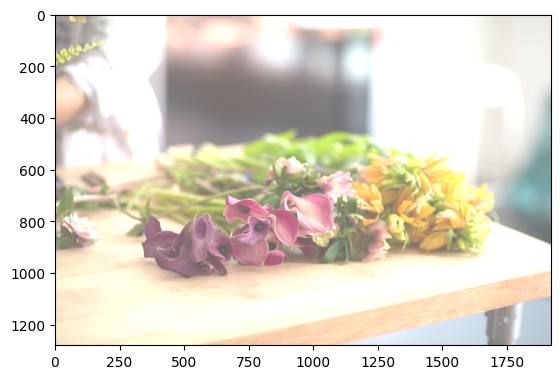

In [383]:
plt.imshow(brightnessAdjust(img3, 0.9));

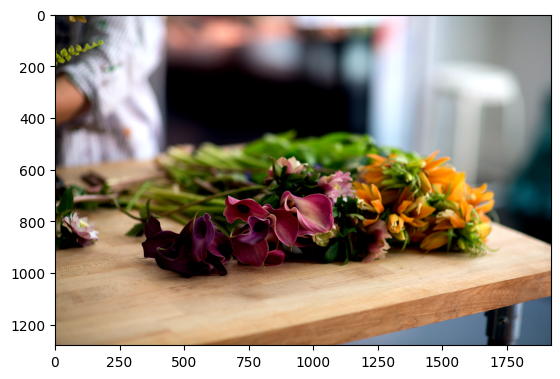

In [386]:
plt.imshow(contastAdjust(img3, 0.9));

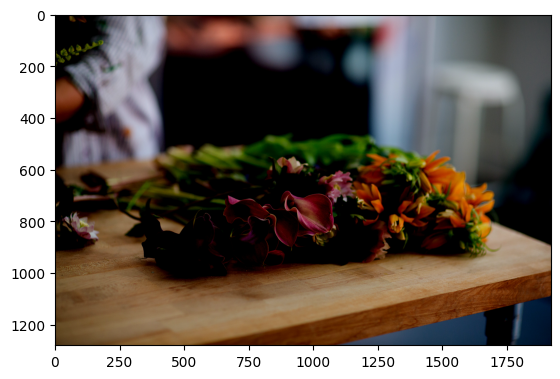

In [390]:
plt.imshow(contastAdjust(brightnessAdjust(img3.copy(), 0.3), 0.9));